## Overview

This is a simple VAE model that uses a convolutional encoder and decoder to learn a latent representation of the input image. 

It's a standard VAE with no tricks so it doesn't work well, but good for learning the basics.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from datetime import datetime
import os
import matplotlib.pyplot as plt

## Code for downloading CIFAR-10

In [2]:
def download_cifar10(data_path='./data'):
    """
    Download CIFAR-10 dataset and return trainset, testset, and classes

    Apply basic transformations to the data to normalize it between [-1, 1]
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_path,
        train=True,
        download=True,
        transform=transform
    )

    testset = torchvision.datasets.CIFAR10(
        root=data_path,
        train=False,
        download=True,
        transform=transform
    )

    print(f"Training set size: {len(trainset)}")
    print(f"Test set size: {len(testset)}")
    
    # CIFAR-10 classes
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck')
    
    return trainset, testset, classes

def get_dataloader(trainset, testset, batch_size=128):
    """Create DataLoader objects for training and testing"""
    train_loader = DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )
    
    test_loader = DataLoader(
        testset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )
    
    return train_loader, test_loader

## Code for Model Definition

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        
        # Encoder, trained to estimate p(z|x) from the input image(s) p(x)
        # p(z|x) is the conditional latent distribution
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), # 16x16 -> 8x8
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # 8x8 -> 4x4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, (latent_dim * 2), 4) # 4x4 -> 1x1
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d((latent_dim), 128, 4), # 1x1 -> 4x4
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # [b, 64, 8, 8]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # [b, 32, 16, 16]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),   # [b, 3, 32, 32]
            nn.Tanh()
        )
    
         
    def encode(self, x):
        x = self.encoder(x) # p(z|x)
        mu, log_var = x.chunk(2, dim=1)
        return mu, log_var
           
    def decode(self, z):
        return self.decoder(z)
    
    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick to sample from the latent 
        distribution while allowing backpropagation
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var
    
    def random_samples(self, num_samples=1, latent_dim=128, device="cuda"):
        """ Generate random samples """
        z = torch.randn(num_samples, 128, 1, 1).to(device)
        samples = self.decode(z)
        
        # Denormalize images from [-1, 1] to [0, 1]
        samples = (samples + 1) / 2
        
        # Move to CPU 
        samples = samples.cpu()
        return samples


In [4]:
def vae_loss_function(recon_x, x, mu, log_var, beta=0.5, epoch=None, warmup_epochs=10):
    # Reconstruction loss:
    # p(x|z) = N(x; μ(z), σ²I)
    # log p(x|z) = -0.5 * (log(2πσ²) + (x - μ(z))²/σ²)
    # log p(x|z) ∝ -0.5 * Σ(x - μ(z))²
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') / x.size(0)

    # KL divergence loss
    # KL(N(μ,σ²) || N(0,1)) = 0.5 * (μ² + σ² - ln(σ²) - 1)
    kl_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=[1, 2, 3]))

    # Apply KL annealing if epoch is provided:
    # This is useful because usually the recon_loss
    # overwhelms the optimizer and we end up in a posterior collapse
    # where the KL Divergence never decreases
    # This is a simple way to gradually increase the KL loss
    # and prevent posterior collapse
    if epoch is not None:
        # Linearly increase beta from 0 to its final value
        beta_weight = min(epoch / warmup_epochs, 1.0) * beta
    else:
        beta_weight = beta

    total_loss = recon_loss + beta_weight*kl_loss
    
    return total_loss, recon_loss, kl_loss

def save_image_samples(model, data, writer, epoch, device):
    """Save original and reconstructed images to tensorboard"""
    model.eval()
    with torch.no_grad():
        # Get reconstructions
        data = data.to(device)
        recon_batch, _, _ = model(data)
        
        data_cpu = data[:8].cpu()
        recon_cpu = recon_batch.cpu()[:8]
        comparison = torch.cat([
            data_cpu,  # Original images
            recon_cpu  # Reconstructed images
        ])
        
        # Add images to tensorboard
        writer.add_images('Original_Reconstructed', comparison, epoch)

def train_epoch(model, train_loader, optimizer, device, writer, epoch):
    model.train()
    
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0
    n_samples = len(train_loader.dataset)

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(data)
        loss, recon_loss, kl_loss = vae_loss_function(recon_batch, data, mu, log_var, epoch=epoch)
        
        loss.backward()
        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    save_image_samples(model, data, writer, epoch, device)  # Using the last batch
    

    avg_loss = train_loss / n_samples
    avg_recon_loss = train_recon_loss / n_samples
    avg_kl_loss = train_kl_loss / n_samples
    
    writer.add_scalar('Loss/train/total', avg_loss, epoch)
    writer.add_scalar('Loss/train/reconstruction', avg_recon_loss, epoch)
    writer.add_scalar('Loss/train/kl_divergence', avg_kl_loss, epoch)
    return avg_loss

In [5]:

def train_vae(epochs=100, batch_size=128, learning_rate=1e-3, device="cuda"):
    # Get data
    trainset, testset, _ = download_cifar10()  # Using your existing function
    train_loader, test_loader = get_dataloader(trainset, testset, batch_size)
    
    # Initialize model, optimizer, and tensorboard
    model = VAE().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    log_dir = f'runs/VAE_CIFAR10_{datetime.now().strftime("%Y%m%d-%H%M%S")}'
    writer = SummaryWriter(log_dir)
    
    # Training loop
    for epoch in range(1, epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, device, writer, epoch)
        
        # Save a checkpoint every 10 epochs
        if epoch % 10 == 0:
            if not os.path.exists(f'{log_dir}/models'):
                os.makedirs(f'{log_dir}/models')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss,
            }, f'{log_dir}/models/vae_checkpoint_epoch_{epoch}.pt')
    
    writer.close()

In [6]:
train_vae(epochs=400, batch_size=128, learning_rate=3e-3, device="cuda")


Files already downloaded and verified
Files already downloaded and verified
Training set size: 50000
Test set size: 10000
Train Epoch: 1 [0/50000 (0%)]	Loss: 12.485578
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.263499
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.690340
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.454651
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.521373
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.392982
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.289097
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.170048
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.224093
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.144992
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.168500
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.202783
Train Epoch: 4 [0/50000 (0%)]	Loss: 1.191165
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.101444
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.094016
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.207761
Train Epoch: 5 [0/50000 (0%)]	Loss: 1.129718
Train Epoch: 5 [12800/50000 (26%)]	Loss: 1.107325
Tr

In [7]:
def generate_and_display_samples(log_dir, epoch=100, num_samples=64, latent_dim=128, device='cuda'):
    """Generate and display random samples from the VAE decoder"""
    model = VAE(latent_dim=128).to(device)
    checkpoint = torch.load(f'{log_dir}/models/vae_checkpoint_epoch_{str(epoch)}.pt', weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    with torch.no_grad():
        samples = model.random_samples(num_samples, latent_dim, device)
        
        # Create a grid of images
        fig, axes = plt.subplots(8, 8, figsize=(9, 9))
        for idx, ax in enumerate(axes.flat):
            # Convert from [C,H,W] to [H,W,C] format
            img = samples[idx].permute(1, 2, 0)
            
            ax.imshow(img)
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return samples

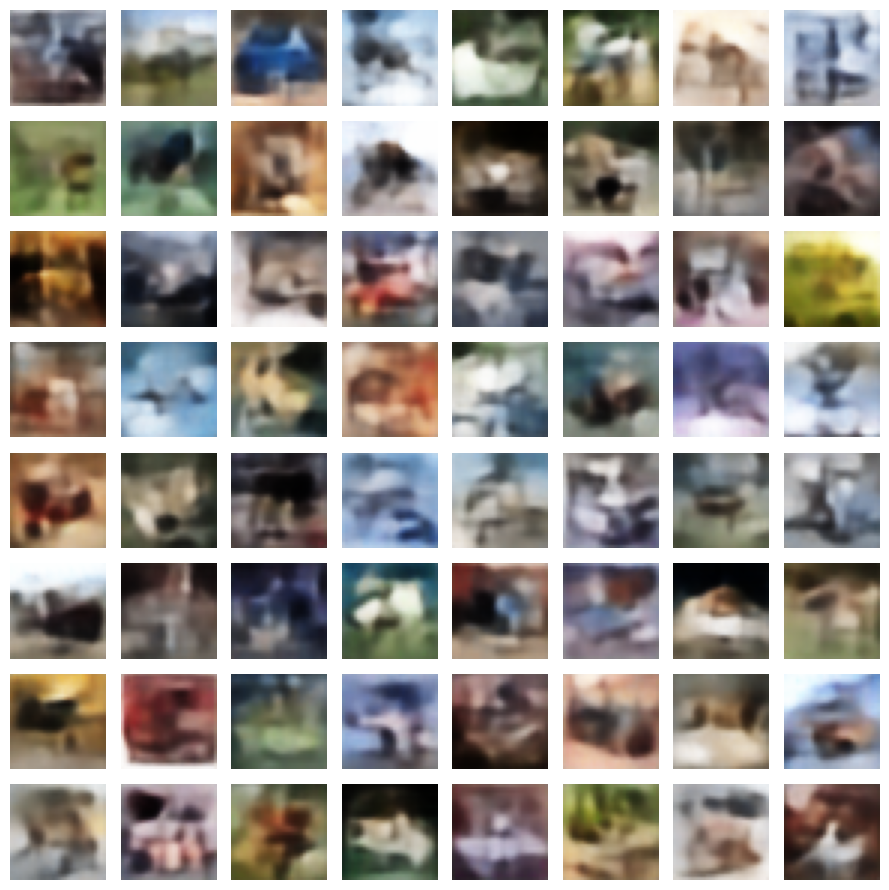

In [19]:
# Initialize a new model instance
log_dir = './runs/VAE_CIFAR10_20241229-193332'
samples = generate_and_display_samples(log_dir, 400)

# Optionally save to disk
torchvision.utils.save_image(samples, 'vae_samples.png', nrow=8, normalize=True)

## Result

As we can see, the generated images are very blurry. This is often an artifact of VAEs. One issue is the MSE loss is directly computed on the pixel space and a minimum MSE is not necessarily a meaningful image.

To get this VAE to work you'd likely need to try some other techniques, like weighting the KL divergence loss or using a perceptual loss instead of the MSE on pixel space. Perceptual loss with an auxilliary pre-trained network can help the model to learn concepts and semantics and focus less on pixel values.